# Notebook to Analyze April 2016 Drift Tracks

In [5]:
import datetime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy.io as sio
from salishsea_tools import tidetools
from salishsea_tools import viz_tools

%matplotlib inline

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [6]:
# Convert from Matlab time to Python Time

# from http://sociograph.blogspot.ca/2011/04/how-to-avoid-gotcha-when-converting.html
def convert_time(matlab_datenum):
    python_datetime = (datetime.datetime.fromordinal(int(matlab_datenum)) 
                   + datetime.timedelta(days=matlab_datenum%1) 
                   - datetime.timedelta(days = 366))
    return python_datetime

In [7]:
# Grid for Background, using the same for both nowcast and nowcast green

grid = nc.Dataset('../../nemo-forcing/grid/bathy_meter_SalishSea2.nc')
bathy, nav_lon, nav_lat = tidetools.get_bathy_data(grid)

In [10]:
# make the plots

def make_drifter_plot(runtype):
    fig, ax = plt.subplots(3, 3, figsize=(15, 20))
    cmap = plt.get_cmap('winter_r')
    cmap.set_bad('burlywood')
    
    directory = '/ocean/sallen/allen/research/MEOPAR/Ariane/AprilDrifters/'


    drifters = sio.loadmat(directory+'driftersPositions.mat')
    for drifterid in [1, 2, 3, 4, 5, 6, 311, 312, 313]:
        mattime = np.array([t[0] for t in drifters['drifters'][0][drifterid-1][4]])
        pytime = []
        for i, time in enumerate(mattime):
            time = convert_time(time)
            pytime.append(time)
    
        drifter ={'name': drifters['drifters'][0][drifterid-1][0][0],
          'id': drifters['drifters'][0][drifterid-1][1][0],
          'lat': np.array([t[0] for t in drifters['drifters'][0][drifterid-1][2]]),
          'lon': np.array([t[0] for t in drifters['drifters'][0][drifterid-1][3]]),
          'time': pytime,
          }

        if drifterid < 4:
            row = 0
            col = drifterid-1
        elif drifterid < 10:
            row = 1
            col = drifterid-1-3
        else:
            row = 2
            col = drifterid-311
        aspect = viz_tools.set_aspect(ax[row, col], coords='map', lats=nav_lat)
        mesh = ax[row, col].pcolormesh(nav_lon[:], nav_lat[:], bathy[:], cmap=cmap)
        cbar = fig.colorbar(mesh, ax=ax[row, col] )
        ax[row, col].axis((-123.6, -122.9, 48.4, 49.5))

        filepattern = 'traj_'+runtype+'_d_'+str(drifterid)+'_'
        for file in glob.glob(directory+filepattern+'*.nc'):
            traj_nowcast = nc.Dataset(file)

            for nt in range(54):
                ax[row, col].plot(traj_nowcast.variables['traj_lon'][:,nt], traj_nowcast.variables['traj_lat'][:,nt], 'ys')
            for nt in range(54,81):
                ax[row, col].plot(traj_nowcast.variables['traj_lon'][:,nt], traj_nowcast.variables['traj_lat'][:,nt], 'y^')
            ax[row, col].plot(traj_nowcast.variables['traj_lon'][:,0], traj_nowcast.variables['traj_lat'][:,0], 'wo')
    
        ax[row, col].plot(drifter['lon'][:], drifter['lat'][:], 'ro', label = 'Observations')
       
        ax[row, col].set_title('Drifter '+str(drifterid)+': Six Hour Segments')
        ax[row, col].legend()
        ax[row, col].set_ylabel('Latitude')
        ax[row, col].set_xlabel('Longitude')

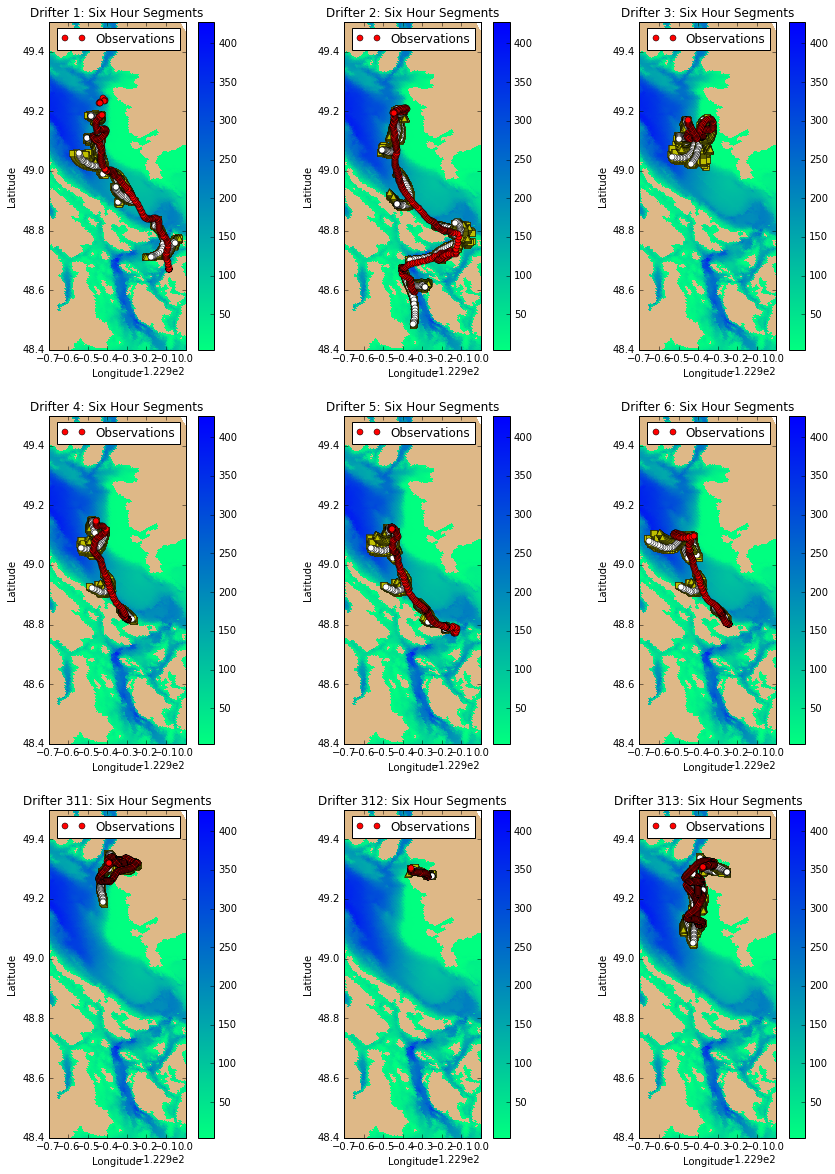

In [11]:
make_drifter_plot('nowcast')

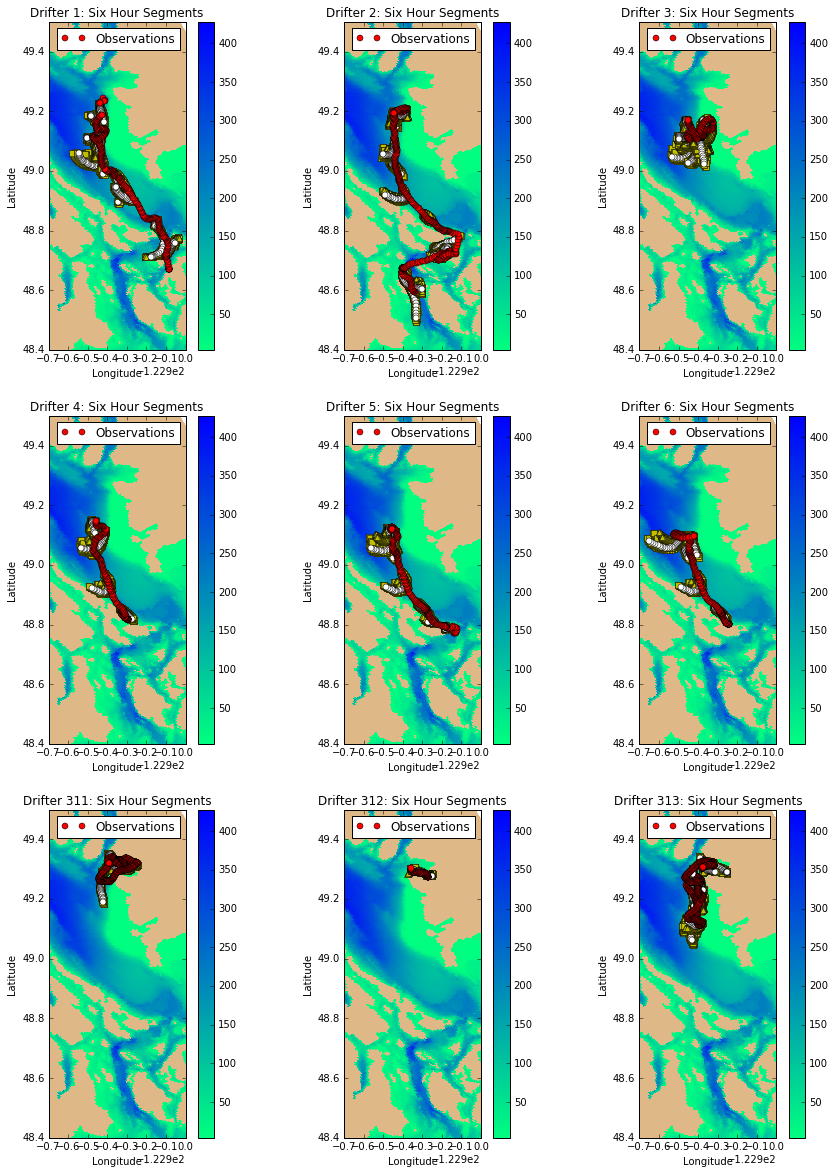

In [12]:
make_drifter_plot('nowcast-green')